# RNN・LSTM(TensorFlow)

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set()

## データ生成

In [3]:
# sin曲線+ノイズ
ts = np.linspace(0, 10 * np.pi, 500)
ys = np.sin(ts) + np.random.normal(scale=0.1, size=len(ts))

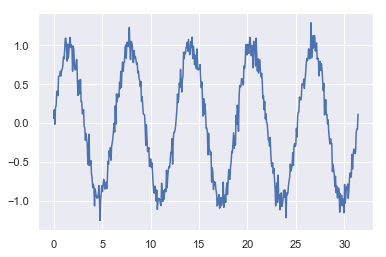

In [4]:
plt.plot(ts, ys)

In [5]:
# 学習設定
batch_size = 32    # ミニバッチサイズ
n_steps = 50       # 入力系列の長さ
input_size = 1     # 入力の次元
hidden_size = 50   #  中間層の次元
output_size = 1    # 出力層の次元

lr = 0.005         # 学習率(SGD)
n_iter = 500       # イテレーション回数

In [6]:
# 訓練データとテストデータに分割
train_ratio = 0.8
data = []
for i in range(len(ys) - n_steps - 1):
    data.append(ys[i: i+n_steps+1])
data = np.array(data, dtype=np.float32)
n_train = int(train_ratio * len(data))
x_train, y_train = np.split(data[:n_train], [-1], axis=1)
x_test, y_test = np.split(data[n_train:], [-1], axis=1)

x_train = np.reshape(x_train, [-1, n_steps, input_size])
x_test = np.reshape(x_test, [-1, n_steps, input_size])

## モデル構築

In [23]:
def inference(x):
    """
    推論（順伝播）
    x: (batch_size, n_steps, input_size)
    """
    # static_rnn関数の引数に適切な形に変形
    x = tf.transpose(x, [1, 0, 2])  # (n_steps, batch_size, input_size)
    x = tf.reshape(x, [-1, input_size])  # (n_steps*batch_size, input_size)
    x = tf.split(x, n_steps, axis=0)  # [(batch_size, input_size)] * n_steps
    
    # RNN(LSTM)セルを定義
    rnn_cell = tf.contrib.rnn.BasicRNNCell(hidden_size)
#     rnn_cell = tf.contrib.rnn.BasicLSTMCell(hidden_size, forget_bias=1.0)
    
    # RNNセルを時間方向に伝播
    hs, _ = tf.contrib.rnn.static_rnn(rnn_cell, x, dtype=tf.float32)
    
    # 出力層の定義
    W_out = tf.Variable(tf.random_normal([hidden_size, output_size]))
    b_out = tf.Variable(tf.random_normal([output_size]))
    return tf.matmul(hs[-1], W_out) + b_out

In [24]:
tf.reset_default_graph()

# 入出力プレースホルダーの定義
x = tf.placeholder("float", [None, n_steps, input_size])
y = tf.placeholder("float", [None, output_size])

# オペレーションの定義
pred = inference(x)
loss = tf.losses.mean_squared_error(y, pred)
# train_step = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(loss)
train_step = tf.train.AdamOptimizer().minimize(loss)

## 学習

In [25]:
init = tf.global_variables_initializer()
# セッション
sess = tf.Session()
# 変数初期化
sess.run(init)

# 訓練データのインデックスをランダムに
perm = np.random.permutation(len(x_train))

for i in range(n_iter):
    idx = (i * batch_size) % len(x_train)
    batch_x, batch_y = x_train[perm[idx: idx+batch_size]], y_train[perm[idx: idx+batch_size]]
    
    feed_dict = {x: batch_x, y: batch_y}
    sess.run(train_step, feed_dict=feed_dict)
    if i % 50 == 0:
        l = sess.run(loss, feed_dict=feed_dict)
        print("step: {}, loss {:.5f}".format(i, l))

step: 0, loss 1.77372
step: 50, loss 0.02403
step: 100, loss 0.01110
step: 150, loss 0.02147
step: 200, loss 0.01120
step: 250, loss 0.01100
step: 300, loss 0.01000
step: 350, loss 0.00972
step: 400, loss 0.01288
step: 450, loss 0.01365


## テスト

In [26]:
# テストデータに対する予測
prediction = sess.run(pred, feed_dict={x: x_test})

# 1次元配列に
prediction = prediction.reshape(-1)
true_y = y_test.reshape(-1)

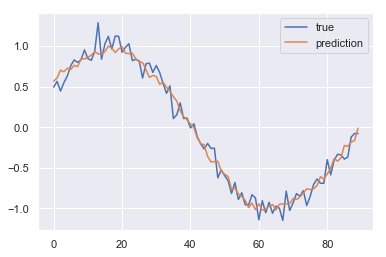

In [27]:
# テストデータに対する予測を可視化
xx = np.arange(len(prediction))
plt.plot(xx, true_y, label='true')
plt.plot(xx, prediction, label='prediction')
plt.legend()

## 再帰的な予測

In [28]:
# テストデータの最初のデータからスタートし、
# モデルの予測を利用し再帰的に予測
curr_x = x_test[0]
predicted = []
# 予測するステップ数
N = 200
for i in range(N):
    # 予測
    predicted.append(sess.run(pred, feed_dict={x: curr_x[None]}))
    # 入力を更新
    curr_x = np.insert(curr_x, n_steps, predicted[-1], axis=0)[1:]

# 1次元配列に
predicted = np.array(predicted).reshape(-1)

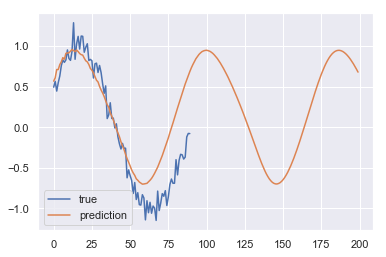

In [29]:
#再帰的な予測を可視化
plt.plot(xx, true_y, label='true')
plt.plot(np.arange(N), predicted, label='prediction')
plt.legend()